Original code from:
https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_googlenet.ipynb

# Get output probabilities

In [ ]:
%%capture
import torch
import torchvision.models as models
from torchvision import transforms
import copy
from PIL import Image

# model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
model = models.googlenet(pretrained=True)  #w/o arg, this will not pretrain it
# model = models.vgg16(pretrained=True)

model.eval() #set model in eval mode: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch

# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
# Download an example image from the pytorch website
# import urllib
# url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
def get_output(model, input_image):
    # input_image = Image.open(input)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    return output
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # print(output[0])  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.

def output_probs(model, input_image):
    output = get_output(model, input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

def get_top_categories(probabilities, categories):
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())


In [ ]:
input_image_1 = Image.open('tigershark.jpg')
input_image_2 = Image.open('greatwhiteshark.jpg')

# probs_tiger_shark = output_probs(model, input_image_1)
# probs_great_white_shark = output_probs(model, input_image_2)

In [ ]:
# get_top_categories(probs_tiger_shark, categories)

In [ ]:
# get_top_categories(probs_great_white_shark, categories)

In [ ]:
# input_image_3 = Image.open('channel-2.png')
# probs_feature_viz = output_probs(model, input_image_3)
# get_top_categories(probs_feature_viz, categories)

---

# Compare neuron activations



**Compare neurons actvs of Tiger Shark vs Great White Shark**

For each layer, or given a layer, rank the neurons that fire the highest. Compare rankings (neuron ind#, actv val)

In [ ]:
#https://discuss.pytorch.org/t/how-to-access-input-output-activations-of-a-layer-given-its-parameters-names/53772

import copy

# need to create new fn b/c activation hook set before sending image thru model
def get_activations(input_image, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    output = model(input_batch)
    return activation.copy()  #else will return the same actvs of model

# make sure to use activation.copy() else this will modify original model's activations!

In [ ]:
layer_to_compare = 'inception3a'
tiger_shark_layer = get_activations(input_image_1, layer_to_compare)
great_white_shark_layer = get_activations(input_image_2, layer_to_compare)

# activation[layer] has dims (# filters, patches along height, patches along width)
# so to get a patch, specify height and width location of patch
# use activation[layer_to_compare][0] b/c has dims (1, x,y,z); the 1 is unneeded
diffs = tiger_shark_layer[layer_to_compare][0] - great_white_shark_layer[layer_to_compare][0]

# diffs_dims = tiger_shark_layer[layer_to_compare][0].shape
# for i in range(diffs_dims[0]):
#     for j in range(diffs_dims[1]):
#         for k in range(diffs_dims[1]):
#             if diffs[i][j][k].item() != 0:
#                 print(i,j,k)

# tiger_shark_layer[layer_to_compare] has 256 matrices of size 28x28
# it has 256 filters

flat_tiger_shark_inception3a = torch.flatten(tiger_shark_layer[layer_to_compare])

# sort from lowest to highest actv
# flat_tiger_shark_inception3a.sort()
sorted, indices = torch.sort(flat_tiger_shark_inception3a)
indices

tensor([     1,      2,      3,  ..., 155259, 155988, 155232], device='cuda:0')

In [ ]:
flat_great_white_shark_inception3a = torch.flatten(great_white_shark_layer[layer_to_compare])
sorted2, indices2 = torch.sort(flat_great_white_shark_inception3a)
indices2

tensor([     1,      2,      3,  ..., 155259, 155988, 155232], device='cuda:0')

In [ ]:
input_image_3 = Image.open('car1.jpg')
car_layer = get_activations(input_image_3, layer_to_compare)
flat_car_inception3a = torch.flatten(car_layer[layer_to_compare])
sorted3, indices3 = torch.sort(flat_car_inception3a)
indices3

tensor([     2,      4,     17,  ..., 155540,  18499,    532], device='cuda:0')

In [ ]:
%%capture
# https://stackoverflow.com/questions/56597964/levenshtein-distance-between-list-of-number

!pip install textdistance
import textdistance

# S1=[1,2,3,7,9,15,19,20]
# S2=[1,2,3,7,8,14,20]

# textdistance.levenshtein.similarity(S1,S2)
# textdistance.levenshtein.distance(S1,S2)

In [ ]:
tiger_shark_actvs_list = indices.tolist()
great_white_shark_actvs_list = indices2.tolist()
car_actvs_list = indices3.tolist()

In [ ]:
new_indices = []
for neuron_num, actv in enumerate(sorted):
    if actv > 0:
        new_indices.append(actv)
print(len(indices))
len(new_indices)

110938

In [ ]:
textdistance.levenshtein.similarity(tiger_shark_actvs_list[-1000:], great_white_shark_actvs_list[-1000:])

13

In [ ]:
textdistance.levenshtein.similarity(tiger_shark_actvs_list[-1000:], car_actvs_list[-1000:])

1

In [ ]:
textdistance.levenshtein.similarity(great_white_shark_actvs_list[-1000:], car_actvs_list[-1000:])

1

As we can see, in terms of the rankings of their neuron firings in channel 0 (a 28x28 filter) of Inception 3a, the two shark images have higher similarity with each other, but very little with car. So this suggests evidence that this channel (neuron, filter) has specific firing patterns for shark vs car.



---

# Compare activations for different levels of abstraction



Now try comparing:
tiger shark 1 vs tiger shark 2 (both tiger sharks)

tiger shark vs great white shark (both sharks)

shark vs dog (both animals)

dog vs car (both have 4 "legs")

shark vs car (unrelated, to a human?)

image w/ only dog vs image w/ dog + cat

face vs face w/o nose

In [ ]:
from google.colab import files
files.upload()

In [ ]:
input_image_4 = Image.open('dog2.jpg')
# probs_dog = output_probs(model, input_image_4)
dog_layer = get_activations(input_image_4, layer_to_compare)
flat_dog_inception3a = torch.flatten(dog_layer[layer_to_compare])
sorted_dog, indices_dog = torch.sort(flat_dog_inception3a)
dog_actvs_list = indices_dog.tolist()

In [ ]:
input_image_5 = Image.open('dog3.jpg')
dog_2_layer = get_activations(input_image_5, layer_to_compare)
flat_dog_2_inception3a = torch.flatten(dog_2_layer[layer_to_compare])
sorted_dog_2, indices_dog_2 = torch.sort(flat_dog_2_inception3a)
dog_2_actvs_list = indices_dog_2.tolist()

In [ ]:
textdistance.levenshtein.similarity(dog_actvs_list[-1000:], dog_2_actvs_list[-1000:])

6

In [ ]:
textdistance.levenshtein.similarity(dog_actvs_list[-1000:], great_white_shark_actvs_list[-1000:])

5

In [ ]:
textdistance.levenshtein.similarity(dog_actvs_list[-1000:], tiger_shark_actvs_list[-1000:])


3

In [ ]:
textdistance.levenshtein.similarity(dog_2_actvs_list[-1000:], great_white_shark_actvs_list[-1000:])

3

In [ ]:
textdistance.levenshtein.similarity(dog_2_actvs_list[-1000:], tiger_shark_actvs_list[-1000:])


3

In [ ]:
textdistance.levenshtein.similarity(dog_actvs_list[-1000:], car_actvs_list[-1000:])

1

In [ ]:
textdistance.levenshtein.similarity(dog_2_actvs_list[-1000:], car_actvs_list[-1000:])

0

As expected, the dogs have most similarity to each other, some similarity to shark, and none to car. Could the neural network be detecting an abstract 'animal class' it learned w/o supervision, or is this a coincidence? Try on more pair examples to determine this.

Is there a way to make these similarities more "prominent" and have more "ordered" rankings according to meaning? Also, a range- normalize?



---



# Find neurons (channels) with highest similarity



---



In [ ]:
# calculate patch # to meaning

In [ ]:
# no need to match to meaning! just find impt neurons that fire high for both!
# find path of high firing. how do we know they do the same thing?



---



# Compare similarities b/w large datasets of image categories



https://ai.googleblog.com/2016/09/introducing-open-images-dataset.html

In [ ]:
!pip uninstall opencv-python-headless #cannot use %%capture if uninstall, but can use if not installed yet
!pip install opencv-python-headless==4.1.2.30

In [ ]:
!pip install --upgrade pip setuptools wheel

In [ ]:
%%capture
!pip install folium==0.2.1

!pip install fiftyone 
import fiftyone
import fiftyone.zoo as foz

In [ ]:
dataset = fiftyone.zoo.load_zoo_dataset(
              "open-images-v6",
              split="validation",
              label_types=["detections", "segmentations"],
              classes=["Cat", "Dog"],
              max_samples=100,
          )

In [ ]:
session = fiftyone.launch_app(dataset)  #3 dots right of cell -> view output full
# session.dataset = dataset  #same as above

In [ ]:
print(dataset)



---



In [ ]:
def get_sorted_neurons(input_image, layer):
    actv_layer = get_activations(input_image, layer)
    flat_layer = torch.flatten(actv_layer[layer])
    sorted, indices = torch.sort(flat_layer)
    return indices.tolist()

def get_levenshtein_sim(image1, image2, layer):
    sorted_neurons_1 = get_sorted_neurons(image1, layer)
    sorted_neurons_2 = get_sorted_neurons(image2, layer)
    return textdistance.levenshtein.similarity(sorted_neurons_1[-100:], sorted_neurons_2[-100:])

In [ ]:
input_image_1 = Image.open('tigershark.jpg')
input_image_2 = Image.open('greatwhiteshark.jpg')

get_levenshtein_sim(input_image_1, input_image_2, 'inception3a')

13



---

https://www.kaggle.com/datasets?search=image

https://www.kaggle.com/iamsouravbanerjee/animal-image-dataset-90-different-animals

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

Must manually upload kaggle.json or put in repo/drive to use code below


In [ ]:
%%capture
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals
! unzip animal-image-dataset-90-different-animals.zip

In [ ]:
f = open("name of the animals.txt", "r")
animals_list = f.readlines()
animals_list = [x.replace('\n','') for x in animals_list]

In [ ]:
import os 
data_dir = 'animals/animals'

antelope_dir = data_dir + '/' + animals_list[0]
len(os.listdir(antelope_dir))
antelope_sample = os.listdir(antelope_dir)[0:10]  #10^2 scores instead of 60^2

In [ ]:
between_antelope_scores = []
# for filename in os.listdir(antelope_dir):
for filename in antelope_sample:
    f = os.path.join(antelope_dir, filename)
    # for filename_2 in os.listdir(antelope_dir):
    for filename_2 in antelope_sample:
        f_2 = os.path.join(antelope_dir, filename_2)
        if f != f_2:
            input_image_1 = Image.open(f)
            input_image_2 = Image.open(f_2)
            sim = get_levenshtein_sim(input_image_1, input_image_2, 'inception3a')
            between_antelope_scores.append(sim)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

(array([52.,  0.,  0., 26.,  0.,  0., 10.,  0.,  0.,  2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

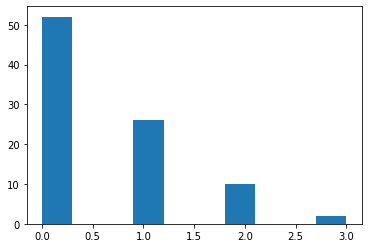

In [ ]:
plt.hist(between_antelope_scores)

(array([51., 29.,  0., 12.,  0.,  5.,  1.,  0.,  1.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

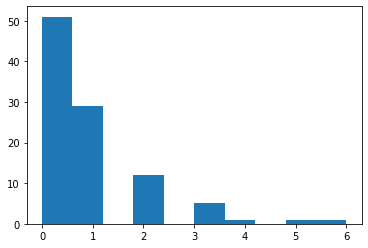

In [ ]:
badger_dir = data_dir + '/badger'
badger_sample = os.listdir(badger_dir)[0:10]

antelope_badger_scores = []
for filename in antelope_sample:
    f = os.path.join(antelope_dir, filename)
    for filename_2 in badger_sample:
        f_2 = os.path.join(badger_dir, filename_2)
        if f != f_2:
            input_image_1 = Image.open(f)
            input_image_2 = Image.open(f_2)
            sim = get_levenshtein_sim(input_image_1, input_image_2, 'inception3a')
            antelope_badger_scores.append(sim)

plt.hist(antelope_badger_scores)

These antelope and badger scores suggest that the Levenshtein distance may not be a good measure for determining image similarity based on activations, unlike the previous fewer case results we saw before. B/w antelope and badger has a greater proportion of higher scores than within antelope, which goes against the hypothesis that images w/ similar classes have higher scores. 

But this only tested the Inception 3a layer. What about a layer w/ higher order features, such as 4c?

10
20
30
40
50
60
70
80
90


(array([70.,  0.,  0.,  0.,  0., 18.,  0.,  0.,  0.,  2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

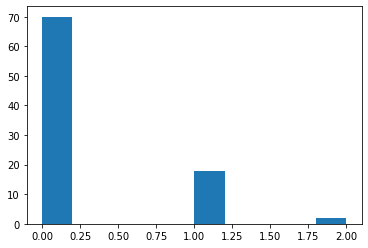

In [ ]:
between_antelope_scores = []
for filename in antelope_sample:
    f = os.path.join(antelope_dir, filename)
    for filename_2 in antelope_sample:
        f_2 = os.path.join(antelope_dir, filename_2)
        if f != f_2:
            input_image_1 = Image.open(f)
            input_image_2 = Image.open(f_2)
            sim = get_levenshtein_sim(input_image_1, input_image_2, 'inception4c')
            between_antelope_scores.append(sim)
            if len(between_antelope_scores) % 10 == 0:
                print(len(between_antelope_scores))
plt.hist(between_antelope_scores)

10
20
30
40
50
60
70
80
90
100


(array([88.,  0.,  0., 10.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

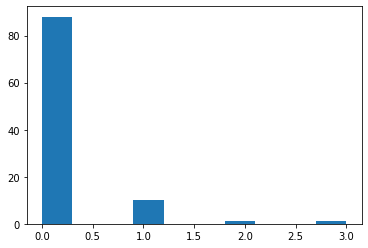

In [ ]:
antelope_badger_scores = []
for filename in antelope_sample:
    f = os.path.join(antelope_dir, filename)
    for filename_2 in badger_sample:
        f_2 = os.path.join(badger_dir, filename_2)
        if f != f_2:
            input_image_1 = Image.open(f)
            input_image_2 = Image.open(f_2)
            sim = get_levenshtein_sim(input_image_1, input_image_2, 'inception4c')
            antelope_badger_scores.append(sim)
            if len(antelope_badger_scores) % 10 == 0:
                print(len(antelope_badger_scores))
plt.hist(antelope_badger_scores)

Again, even in inception 4c, antelope-badger scores have higher frequency of higher scores. This suggests that this is not a good measure; it is a negative result, suggesting that we should not use this approach, and others should not use it either.

What may have happened earlier is that the shark images were very similar overall- both had oceans, sharks in front view. Same with dogs- they showed the dog profiles. For this dataset, the antelopes have varied poses and positions. Still, there must be something suggesting they are antelopes. Ranking is not the only way to investigate this.

Certain badger pictures may have more similarity with antelope pictures due to the profile, presence of trees, etc. For high sim pairs, output their names and load them to see what they look like. 

But even with high sim in layer 4c, it's about what the output prob is. Work backwards; try starting from penultimate layer then back.

Additionally, previously used the top 1000, but this used the top 100, as L. dist is slow to compute. Try a faster similarity metric.

Another thing to note is that, for Inception 4c, if we take a dot product of the counts with the values, we get a weighted score that suggests within antelope is higher! So perhaps looking at the graph was misleading.



In [ ]:
#inception4c

within_antelope_counts = [70.,  0.,  0.,  0.,  0., 18.,  0.,  0.,  0.,  2.]
within_antelope_weights = [0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]
within_antelope_weighted_score = sum([x*y for x,y in zip(within_antelope_counts,within_antelope_weights)])

antelope_badger_counts = [88.,  0.,  0., 10.,  0.,  0.,  1.,  0.,  0.,  1.]
antelope_badger_weights = [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]
antelope_badger_weighted_score = sum([x*y for x,y in zip(antelope_badger_counts,antelope_badger_weights)])

print(within_antelope_weighted_score)
print(antelope_badger_weighted_score)

21.6
13.5


Note that there was yet another error in comparing these two histograms- within-antelope only has 90 unique image pairs because it skips comparing the same images, whereas antelope-badger has 100 image pairs. So comparing the pairs by only frequency is a flawed method due to the different total counts in the two populations.

10
20
30
40
50
60
70
80
90
100


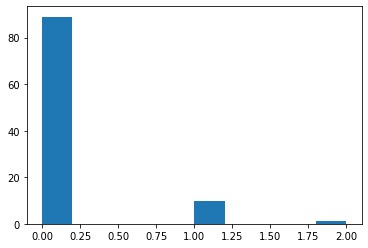

In [ ]:
def get_categories_scores(sample1_dir, sample2_dir, layer):
    sample1 = os.listdir(sample1_dir)[0:10]
    sample2 = os.listdir(sample2_dir)[0:10]
    categories_scores = []
    for filename in sample1:
        f = os.path.join(sample1_dir, filename)
        for filename_2 in sample2:
            f_2 = os.path.join(sample2_dir, filename_2)
            if f != f_2:
                input_image_1 = Image.open(f)
                input_image_2 = Image.open(f_2)
                sim = get_levenshtein_sim(input_image_1, input_image_2, layer)
                categories_scores.append(sim)
                if len(categories_scores) % 10 == 0:
                    print(len(categories_scores))
    counts, bins, bars = plt.hist(categories_scores)
    return counts, bins, bars

antelope_dir = data_dir + '/antelope'
badger_dir = data_dir + '/badger'
counts, bins, bars = get_categories_scores(antelope_dir, badger_dir, 'inception4c')

In [ ]:
antelope_badger_weighted_score = sum([x*y for x,y in zip(counts,bins)])
antelope_badger_weighted_score

11.8

In [ ]:
counts

array([89.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  1.])

10
20
30
40
50
60
70
80
90
100


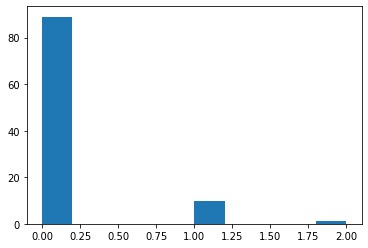

In [ ]:
def get_categories_scores(sample1_dir, sample2_dir, layer):
    sample1 = os.listdir(sample1_dir)[0:10]
    sample2 = os.listdir(sample2_dir)[0:10]
    categories_scores = []
    for filename in sample1:
        f = os.path.join(sample1_dir, filename)
        for filename_2 in sample2:
            f_2 = os.path.join(sample2_dir, filename_2)
            if f != f_2:
                input_image_1 = Image.open(f)
                input_image_2 = Image.open(f_2)
                sim = get_levenshtein_sim(input_image_1, input_image_2, layer)
                categories_scores.append(sim)
                if len(categories_scores) % 10 == 0:
                    print(len(categories_scores))
    counts, bins, bars = plt.hist(categories_scores)
    return counts, bins, bars

antelope_dir = data_dir + '/antelope'
badger_dir = data_dir + '/badger'
counts, bins, bars = get_categories_scores(antelope_dir, badger_dir, 'inception4c')

In [ ]:
antelope_badger_weighted_score = sum([x*y for x,y in zip(counts,bins)])
antelope_badger_weighted_score

11.8

In [ ]:
counts

array([89.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  1.])

Strangely, the new score is different than before, but it's deterministic (same result after run twice).

10
20
30
40
50
60
70
80
90
100


(array([89.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

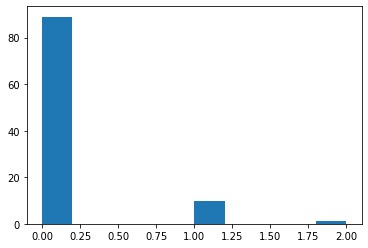

In [ ]:
badger_sample = os.listdir(badger_dir)[0:10]
antelope_badger_scores = []
for filename in antelope_sample:
    f = os.path.join(antelope_dir, filename)
    for filename_2 in badger_sample:
        f_2 = os.path.join(badger_dir, filename_2)
        if f != f_2:
            input_image_1 = Image.open(f)
            input_image_2 = Image.open(f_2)
            sim = get_levenshtein_sim(input_image_1, input_image_2, 'inception4c')
            antelope_badger_scores.append(sim)
            if len(antelope_badger_scores) % 10 == 0:
                print(len(antelope_badger_scores))
plt.hist(antelope_badger_scores)

SOLN: old code shows same counts as new code, but different from previous session. So it seems the counts are different b/w sessions. My theory for this randomness is b/c the sorting is random- due to some counts having the same value (such as the 0s), the randomness sometimes places different elements with the same value in different order, depending on the session. Though it would probably not be a 0 as before there were 88 0's, and now there are 89 0's.



---



# Compare b/w categories for multiple layers

Look at specific antelope vs badger activations across multiple layers. Work backwards.

10
20
30
40
50
60
70
80
90
100


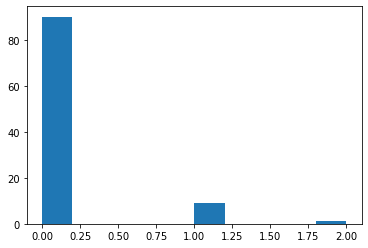

In [ ]:
antelope_dir = data_dir + '/antelope'
badger_dir = data_dir + '/badger'
counts, bins, bars = get_categories_scores(antelope_dir, badger_dir, 'inception5e')

In [ ]:
antelope_badger_weighted_score = sum([x*y for x,y in zip(counts,bins)])
antelope_badger_weighted_score

10.8

10
20
30
40
50
60
70
80
90


128.0

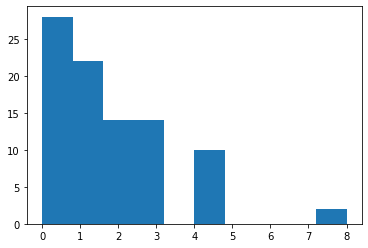

In [ ]:
counts, bins, bars = get_categories_scores(antelope_dir, antelope_dir, 'inception5e')
within_antelope_weighted_score = sum([x*y for x,y in zip(counts,bins)])
within_antelope_weighted_score

Inception 5e shows a HUGE weighted score for b/w antelope compared to antelope-badger!

Remember, InceptionV3 has more layers than InceptionV1. It's strange that this is InceptionV3, since googlenet is InceptionV1?

https://microscope.openai.com/models/inceptionv3_slim?models.technique=deep_dream

10
20
30
40
50
60
70
80
90
100
Antelope-badger:  10.8
10
20
30
40
50
60
70
80
90
Antelope-Antelope:  128.0


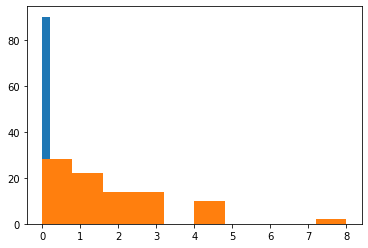

In [ ]:
def get_weighted_scores(sample1_dir, sample2_dir, layer):
    counts,bins,bars = get_categories_scores(sample1_dir, sample2_dir, layer)
    return sum([x*y for x,y in zip(counts,bins)])

print("Antelope-badger: ", get_weighted_scores(antelope_dir, badger_dir, 'inception7c'))
print("Antelope-Antelope: ", get_weighted_scores(antelope_dir, antelope_dir, 'inception7c'))

# NOTE: putting two histograms in same cell will result in them overlapping each other!

Why do 7c and 5e have the same score?

10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
Antelope-badger:  1.8
Antelope-Antelope:  13.0


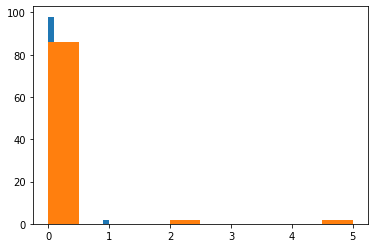

In [ ]:
score_1 = get_weighted_scores(antelope_dir, badger_dir, 'inception4e')
score_2 = get_weighted_scores(antelope_dir, antelope_dir, 'inception4e') 
print("Antelope-badger: ", score_1)
print("Antelope-Antelope: ", score_2)

10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
Antelope-badger:  10.8
Antelope-Antelope:  128.0


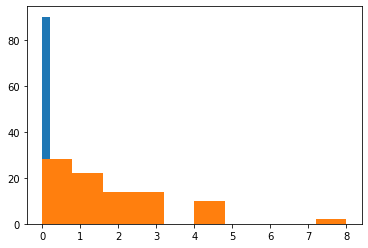

In [ ]:
score_1 = get_weighted_scores(antelope_dir, badger_dir, 'inception7c')
score_2 = get_weighted_scores(antelope_dir, antelope_dir, 'inception7c') 
print("Antelope-badger: ", score_1)
print("Antelope-Antelope: ", score_2)

It seems that running the print() not around the function doesn't make a difference in scores; 7c and 5e really do have the same scores. If a layer in b/w them has the same score, it suggests evidence that some layer, perhaps 5e, is a "converged layer" that has decided what is antelope vs badger, so those neurons after those layer will all have same firing pattern (highest activations) for antelopes vs badgers. Meaning, just by looking at those neurons, one can tell what is antelope vs badger.

10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
Antelope-badger:  10.8
Antelope-Antelope:  128.0


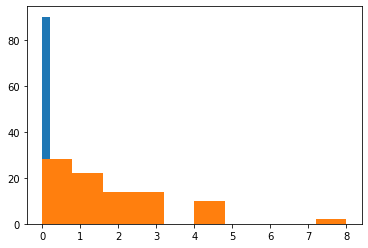

In [ ]:
score_1 = get_weighted_scores(antelope_dir, badger_dir, 'inception6e')
score_2 = get_weighted_scores(antelope_dir, antelope_dir, 'inception6e') 
print("Antelope-badger: ", score_1)
print("Antelope-Antelope: ", score_2)

6e also has same scores, whereas 4e doesn't. So somewhere between 4e and 5e, it "converges" for these top 100 highest neurons?

In [ ]:
named_layers = dict(model.named_modules())
named_layers.keys()

dict_keys(['', 'conv1', 'conv1.conv', 'conv1.bn', 'maxpool1', 'conv2', 'conv2.conv', 'conv2.bn', 'conv3', 'conv3.conv', 'conv3.bn', 'maxpool2', 'inception3a', 'inception3a.branch1', 'inception3a.branch1.conv', 'inception3a.branch1.bn', 'inception3a.branch2', 'inception3a.branch2.0', 'inception3a.branch2.0.conv', 'inception3a.branch2.0.bn', 'inception3a.branch2.1', 'inception3a.branch2.1.conv', 'inception3a.branch2.1.bn', 'inception3a.branch3', 'inception3a.branch3.0', 'inception3a.branch3.0.conv', 'inception3a.branch3.0.bn', 'inception3a.branch3.1', 'inception3a.branch3.1.conv', 'inception3a.branch3.1.bn', 'inception3a.branch4', 'inception3a.branch4.0', 'inception3a.branch4.1', 'inception3a.branch4.1.conv', 'inception3a.branch4.1.bn', 'inception3b', 'inception3b.branch1', 'inception3b.branch1.conv', 'inception3b.branch1.bn', 'inception3b.branch2', 'inception3b.branch2.0', 'inception3b.branch2.0.conv', 'inception3b.branch2.0.bn', 'inception3b.branch2.1', 'inception3b.branch2.1.conv', 'i

10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
Antelope-badger:  2.7
Antelope-Antelope:  22.4


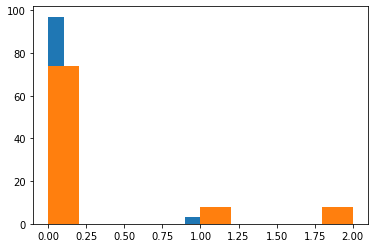

In [ ]:
score_1 = get_weighted_scores(antelope_dir, badger_dir, 'inception5a')
score_2 = get_weighted_scores(antelope_dir, antelope_dir, 'inception5a') 
print("Antelope-badger: ", score_1)
print("Antelope-Antelope: ", score_2)

Loop thru 5a to 5e and record them 

In [ ]:
antelope_antelope_scores = {}
antelope_badger_scores = {}
layers = ['inception5a', 'inception5b','inception5c','inception5d','inception5e','inception6a',]

for layer in layers:
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer) 

In [ ]:
antelope_antelope_scores

{'inception5a': 22.4,
 'inception5b': 15.0,
 'inception5c': 128.0,
 'inception5d': 128.0,
 'inception5e': 128.0,
 'inception6a': 128.0}

In [ ]:
antelope_badger_scores

{'inception5a': 2.7,
 'inception5b': 1.8,
 'inception5c': 10.8,
 'inception5d': 10.8,
 'inception5e': 10.8,
 'inception6a': 10.8}

Actually, a mistake was made before. This is NOT InceptionV3; this is InceptionV1 (googlenet), so perhaps using layer '7c' made it default to the highest layer, same with 5e. That is actually PRECISELY what's happening; 5a and 5b (the penultimate layers) of InceptionV1 have different scores, but 5c and above (which default to probably the output layer) all have same scores. So there's no 'convergence' happening. 

However, we do see that the layers of 5a and 5b have higher scores for antelope-antelope than antelope-badger. At what layer does it start to realize the differences? Compare for multiple layers.

In [ ]:
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# too many branches, so just get the converged branch points
layers = [x for x in layers if '.' not in x]
layers[1:]  # '' is first layer, the input, so disregard it

['conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'dropout',
 'fc']

In [ ]:
%%capture
antelope_antelope_scores = {}
antelope_badger_scores = {}

for layer in layers:
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer) 

In [ ]:
antelope_antelope_scores

{'': 128.0,
 'avgpool': 62.39999999999999,
 'conv1': 10.799999999999999,
 'conv2': 18.0,
 'conv3': 11.6,
 'dropout': 62.39999999999999,
 'fc': 128.0,
 'inception3a': 54.4,
 'inception3b': 111.60000000000001,
 'inception4a': 7.2,
 'inception4b': 27.599999999999994,
 'inception4c': 9.0,
 'inception4d': 22.799999999999997,
 'inception4e': 13.0,
 'inception5a': 22.4,
 'inception5b': 15.0,
 'maxpool1': 23.400000000000002,
 'maxpool2': 16.799999999999997,
 'maxpool3': 72.19999999999999,
 'maxpool4': 19.0}

In [ ]:
antelope_badger_scores

{'': 10.8,
 'avgpool': 8.1,
 'conv1': 0.9,
 'conv2': 1.8,
 'conv3': 11.700000000000001,
 'dropout': 8.1,
 'fc': 10.8,
 'inception3a': 67.89999999999999,
 'inception3b': 127.20000000000002,
 'inception4a': 1.8,
 'inception4b': 15.2,
 'inception4c': 11.8,
 'inception4d': 4.5,
 'inception4e': 1.8,
 'inception5a': 2.7,
 'inception5b': 1.8,
 'maxpool1': 0.0,
 'maxpool2': 22.4,
 'maxpool3': 137.5,
 'maxpool4': 3.6}

Interestingly enough, any 'unknown' layer defaults to fc's score. Also this dict is not the best way to organize as it does not go by layer's order (should've just used list). But we see IMMEDIATELY from conv1 that antelope-antelope has a higher score than antelope-badger! Strangely enough, at conv3, the two have the same score! And then, antelope-badger has a higher score in 3a and 3b until 4a. Why?

In [ ]:
for layer in layers[1:]:
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer], 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer], 2))

conv1
    antelope_antelope_scores:  10.8
    antelope_badger_scores:    0.9
maxpool1
    antelope_antelope_scores:  23.4
    antelope_badger_scores:    0.0
conv2
    antelope_antelope_scores:  18.0
    antelope_badger_scores:    1.8
conv3
    antelope_antelope_scores:  11.6
    antelope_badger_scores:    11.7
maxpool2
    antelope_antelope_scores:  16.8
    antelope_badger_scores:    22.4
inception3a
    antelope_antelope_scores:  54.4
    antelope_badger_scores:    67.9
inception3b
    antelope_antelope_scores:  111.6
    antelope_badger_scores:    127.2
maxpool3
    antelope_antelope_scores:  72.2
    antelope_badger_scores:    137.5
inception4a
    antelope_antelope_scores:  7.2
    antelope_badger_scores:    1.8
inception4b
    antelope_antelope_scores:  27.6
    antelope_badger_scores:    15.2
inception4c
    antelope_antelope_scores:  9.0
    antelope_badger_scores:    11.8
inception4d
    antelope_antelope_scores:  22.8
    antelope_badger_scores:    4.5
inception4e
    antelop

It's not just 3a and 3b; 4c also shows antelope-badger having a higher score. Again, this may change if we consider more neurons than the top 100. But a hypothesis for this may be that 4c is detecting features not specific to antelopes or badgers, but perhaps background elements such as trees, which may be common for those 10 images selected for each category (but why not within category?)

Remember this is a crude measurement, so one cannot interpret say, absolute rankings and ratios, with certainty. They only suggest "perhaps it is this way, and one should focus their efforts to determine if this pattern is real using other methods, more so than on other areas with no such pattern".

Perhaps try looking at layers in b/w that area, including branches, to pinpoint more precisely the changes.

In [ ]:
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# each branch has conv and bn, perhaps disregard those
layers = [x for x in layers if ('inception3' in x or 'inception4' in x) \
          and ('conv' not in x) and ('bn' not in x) and 'inception4e' not in x]
layers

In [ ]:
# as seen on left, took 46 mins to run

%%capture
antelope_antelope_scores_zoom = {}
antelope_badger_scores_zoom = {}

for layer in layers:
    antelope_antelope_scores_zoom[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer) 
    antelope_badger_scores_zoom[layer] = get_weighted_scores(antelope_dir, badger_dir, layer)

In [ ]:
for layer in layers:
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores_zoom[layer], 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores_zoom[layer], 2))

inception3a
    antelope_antelope_scores:  54.4
    antelope_badger_scores:    67.9
inception3a.branch1
    antelope_antelope_scores:  11.0
    antelope_badger_scores:    5.8
inception3a.branch2
    antelope_antelope_scores:  16.8
    antelope_badger_scores:    21.4
inception3a.branch2.0
    antelope_antelope_scores:  18.2
    antelope_badger_scores:    15.8
inception3a.branch2.1
    antelope_antelope_scores:  16.8
    antelope_badger_scores:    21.4
inception3a.branch3
    antelope_antelope_scores:  79.8
    antelope_badger_scores:    126.0
inception3a.branch3.0
    antelope_antelope_scores:  26.0
    antelope_badger_scores:    5.4
inception3a.branch3.1
    antelope_antelope_scores:  79.8
    antelope_badger_scores:    126.0
inception3a.branch4
    antelope_antelope_scores:  204.0
    antelope_badger_scores:    192.6
inception3a.branch4.0
    antelope_antelope_scores:  60.8
    antelope_badger_scores:    73.0
inception3a.branch4.1
    antelope_antelope_scores:  204.0
    antelope_badg

There is a sudden shift from 4c to 4d where antelope-antelope has higher scores, not gradual. Actually, all the branches before 4d have mixed results; at 4d, antelope-antelope dominates, but not by much (since it is a crude metric, it is harder to tell what "a lot" of difference means)



---



# Try Jaccard for top 100

In [ ]:
%%capture
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals
! unzip animal-image-dataset-90-different-animals.zip

In [ ]:
f = open("name of the animals.txt", "r")
animals_list = f.readlines()
animals_list = [x.replace('\n','') for x in animals_list]

In [ ]:
import copy

top_neurons_dict = {} # (image, layer) : top 100 neurons

# need to create new fn b/c activation hook set before sending image thru model
def get_activations(input_image, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    output = model(input_batch)
    return activation.copy()  #else will return the same actvs of model
    
def get_sorted_neurons(input_image, layer, filename):
    actv_layer = get_activations(input_image, layer)
    flat_layer = torch.flatten(actv_layer[layer])
    sorted, indices = torch.sort(flat_layer)
    top_neurons_dict[(filename, layer)] = indices.tolist()
    return indices.tolist()

In [ ]:
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

def get_jaccard_sim(image1, image2, layer, f, f_2, topNum):
    if (f, layer) in top_neurons_dict:
        sorted_neurons_1 = top_neurons_dict[(f, layer)]
    else:
        sorted_neurons_1 = get_sorted_neurons(image1, layer, f)
    if (f_2, layer) in top_neurons_dict:
        sorted_neurons_2 = top_neurons_dict[(f_2, layer)]
    else:
        sorted_neurons_2 = get_sorted_neurons(image2, layer, f_2)
    return jaccard_similarity(sorted_neurons_1[-topNum:], sorted_neurons_2[-topNum:])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os 
data_dir = 'animals/animals'

def get_categories_scores(sample1_dir, sample2_dir, layer, topNum):
    sample1 = os.listdir(sample1_dir)[0:10]
    sample2 = os.listdir(sample2_dir)[0:10]
    categories_scores = []
    for filename in sample1:
        f = os.path.join(sample1_dir, filename)
        for filename_2 in sample2:
            f_2 = os.path.join(sample2_dir, filename_2)
            if f != f_2:
                input_image_1 = Image.open(f)
                input_image_2 = Image.open(f_2)
                sim = get_jaccard_sim(input_image_1, input_image_2, layer, f, f_2, topNum)
                categories_scores.append(sim)
                if len(categories_scores) % 10 == 0:
                    print(len(categories_scores))
    counts, bins, bars = plt.hist(categories_scores)
    return counts, bins, bars

def get_weighted_scores(sample1_dir, sample2_dir, layer, topNum):
    counts,bins,bars = get_categories_scores(sample1_dir, sample2_dir, layer, topNum)
    return sum([x*y for x,y in zip(counts,bins)])

In [ ]:
antelope_dir = data_dir + '/antelope'
badger_dir = data_dir + '/badger'

In [ ]:
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# too many branches, so just get the converged branch points
layers = [x for x in layers if '.' not in x]
layers[1:]  # '' is first layer, the input, so disregard it

['conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'dropout',
 'fc']

In [ ]:
%%capture
antelope_antelope_scores = {}
antelope_badger_scores = {}
topNum = 10

# for each (image, layer), calc and store actvs once
# create class or global var dict of (image, layer) : top 100 neurons

for layer in layers:
    if layer == '':
        continue
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer, topNum)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer, topNum) 

Above code runs 6m w/o memoizing top neurons.

After memoizing, runs in 35secs.

In [ ]:
# top 100

for layer in layers:
    if layer == '':
        continue
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer], 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer], 2))

conv1
    antelope_antelope_scores:  0.5
    antelope_badger_scores:    2.18
maxpool1
    antelope_antelope_scores:  0.55
    antelope_badger_scores:    2.4
conv2
    antelope_antelope_scores:  0.95
    antelope_badger_scores:    1.04
conv3
    antelope_antelope_scores:  0.88
    antelope_badger_scores:    0.87
maxpool2
    antelope_antelope_scores:  2.27
    antelope_badger_scores:    2.79
inception3a
    antelope_antelope_scores:  11.96
    antelope_badger_scores:    13.13
inception3b
    antelope_antelope_scores:  6.55
    antelope_badger_scores:    6.06
maxpool3
    antelope_antelope_scores:  6.14
    antelope_badger_scores:    6.51
inception4a
    antelope_antelope_scores:  2.9
    antelope_badger_scores:    2.51
inception4b
    antelope_antelope_scores:  6.91
    antelope_badger_scores:    6.94
inception4c
    antelope_antelope_scores:  2.78
    antelope_badger_scores:    2.72
inception4d
    antelope_antelope_scores:  2.9
    antelope_badger_scores:    1.98
inception4e
    antel

Jaccard Sim is very bad for this purpose; many of the layer share the same top 100 neurons.

Try for only top 10 neurons

In [ ]:
# top 10

for layer in layers:
    if layer == '':
        continue
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer], 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer], 2))

conv1
    antelope_antelope_scores:  0.0
    antelope_badger_scores:    0.26
maxpool1
    antelope_antelope_scores:  0.0
    antelope_badger_scores:    0.57
conv2
    antelope_antelope_scores:  0.0
    antelope_badger_scores:    0.14
conv3
    antelope_antelope_scores:  2.29
    antelope_badger_scores:    3.06
maxpool2
    antelope_antelope_scores:  2.47
    antelope_badger_scores:    3.22
inception3a
    antelope_antelope_scores:  7.86
    antelope_badger_scores:    9.26
inception3b
    antelope_antelope_scores:  17.87
    antelope_badger_scores:    20.67
maxpool3
    antelope_antelope_scores:  12.78
    antelope_badger_scores:    16.99
inception4a
    antelope_antelope_scores:  0.95
    antelope_badger_scores:    0.68
inception4b
    antelope_antelope_scores:  1.45
    antelope_badger_scores:    2.9
inception4c
    antelope_antelope_scores:  2.51
    antelope_badger_scores:    2.1
inception4d
    antelope_antelope_scores:  0.56
    antelope_badger_scores:    0.9
inception4e
    antel

For most layers, top 10 is worse; now, antelope-badger shows more sim than antelope-antelope!

In [ ]:
%%capture
antelope_antelope_scores = {}
antelope_badger_scores = {}
topNum = 1000

# for each (image, layer), calc and store actvs once
# create class or global var dict of (image, layer) : top 100 neurons

for layer in layers:
    if layer == '':
        continue
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer, topNum)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer, topNum) 

In [ ]:
# top 1000. normalize by # of pairs

for layer in layers:
    if layer == '':
        continue
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer] / 90, 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer] / 100, 2))

conv1
    antelope_antelope_scores:  0.01
    antelope_badger_scores:    0.01
maxpool1
    antelope_antelope_scores:  0.01
    antelope_badger_scores:    0.01
conv2
    antelope_antelope_scores:  0.2
    antelope_badger_scores:    0.16
conv3
    antelope_antelope_scores:  0.1
    antelope_badger_scores:    0.12
maxpool2
    antelope_antelope_scores:  0.28
    antelope_badger_scores:    0.33
inception3a
    antelope_antelope_scores:  0.12
    antelope_badger_scores:    0.11
inception3b
    antelope_antelope_scores:  0.13
    antelope_badger_scores:    0.11
maxpool3
    antelope_antelope_scores:  0.17
    antelope_badger_scores:    0.15
inception4a
    antelope_antelope_scores:  0.09
    antelope_badger_scores:    0.08
inception4b
    antelope_antelope_scores:  0.2
    antelope_badger_scores:    0.19
inception4c
    antelope_antelope_scores:  0.11
    antelope_badger_scores:    0.11
inception4d
    antelope_antelope_scores:  0.09
    antelope_badger_scores:    0.08
inception4e
    antelo

However, if we normalize by the number of pairs, we see antelope-antelope is slightly higher. Still, it's so close that it's not a good metric to differentiate.

In [ ]:
%%capture
antelope_antelope_scores = {}
antelope_badger_scores = {}
topNum = 10000

# for each (image, layer), calc and store actvs once
# create class or global var dict of (image, layer) : top 100 neurons

for layer in layers:
    if layer == '':
        continue
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer, topNum)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer, topNum) 

In [ ]:
# top 10000. normalize by # of pairs

for layer in layers:
    if layer == '':
        continue
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer] / 90, 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer] / 100, 2))

conv1
    antelope_antelope_scores:  0.2
    antelope_badger_scores:    0.14
maxpool1
    antelope_antelope_scores:  0.43
    antelope_badger_scores:    0.44
conv2
    antelope_antelope_scores:  0.38
    antelope_badger_scores:    0.36
conv3
    antelope_antelope_scores:  0.27
    antelope_badger_scores:    0.25
maxpool2
    antelope_antelope_scores:  0.39
    antelope_badger_scores:    0.38
inception3a
    antelope_antelope_scores:  0.25
    antelope_badger_scores:    0.22
inception3b
    antelope_antelope_scores:  0.21
    antelope_badger_scores:    0.18
maxpool3
    antelope_antelope_scores:  0.23
    antelope_badger_scores:    0.22
inception4a
    antelope_antelope_scores:  0.15
    antelope_badger_scores:    0.13
inception4b
    antelope_antelope_scores:  0.19
    antelope_badger_scores:    0.17
inception4c
    antelope_antelope_scores:  0.19
    antelope_badger_scores:    0.18
inception4d
    antelope_antelope_scores:  0.14
    antelope_badger_scores:    0.13
inception4e
    ante

Why is top 10000 faster? But top 100,000 is not, and is slower?

In [ ]:
%%capture
antelope_antelope_scores = {}
antelope_badger_scores = {}
topNum = 100000

# for each (image, layer), calc and store actvs once
# create class or global var dict of (image, layer) : top 100 neurons

for layer in layers:
    if layer == '':
        continue
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer, topNum)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer, topNum) 

In [ ]:
# top 100000. normalize by # of pairs

for layer in layers:
    if layer == '':
        continue
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer] / 90, 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer] / 100, 2))

conv1
    antelope_antelope_scores:  0.26
    antelope_badger_scores:    0.26
maxpool1
    antelope_antelope_scores:  0.72
    antelope_badger_scores:    0.71
conv2
    antelope_antelope_scores:  0.52
    antelope_badger_scores:    0.49
conv3
    antelope_antelope_scores:  0.53
    antelope_badger_scores:    0.5
maxpool2
    antelope_antelope_scores:  0.63
    antelope_badger_scores:    0.61
inception3a
    antelope_antelope_scores:  0.47
    antelope_badger_scores:    0.46
inception3b
    antelope_antelope_scores:  0.33
    antelope_badger_scores:    0.31
maxpool3
    antelope_antelope_scores:  1.0
    antelope_badger_scores:    1.0
inception4a
    antelope_antelope_scores:  1.0
    antelope_badger_scores:    1.0
inception4b
    antelope_antelope_scores:  1.0
    antelope_badger_scores:    1.0
inception4c
    antelope_antelope_scores:  1.0
    antelope_badger_scores:    1.0
inception4d
    antelope_antelope_scores:  0.97
    antelope_badger_scores:    0.97
inception4e
    antelope_ant

At a certain point, this metric isn't good. Perhaps because there's a different number of neurons at each point. Instead of having fixed top ranking, it should be top 10%.

In [ ]:
def get_jaccard_sim(image1, image2, layer, f, f_2, topPerc):
    if (f, layer) in top_neurons_dict:
        sorted_neurons_1 = top_neurons_dict[(f, layer)]
    else:
        sorted_neurons_1 = get_sorted_neurons(image1, layer, f)
    if (f_2, layer) in top_neurons_dict:
        sorted_neurons_2 = top_neurons_dict[(f_2, layer)]
    else:
        sorted_neurons_2 = get_sorted_neurons(image2, layer, f_2)
    topNum = round(len(sorted_neurons_1)*topPerc)
    return jaccard_similarity(sorted_neurons_1[-topNum:], sorted_neurons_2[-topNum:])

In [ ]:
%%capture
antelope_antelope_scores = {}
antelope_badger_scores = {}
topPerc = 0.1

# for each (image, layer), calc and store actvs once
# create class or global var dict of (image, layer) : top 100 neurons

for layer in layers:
    if layer == '':
        continue
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer, topPerc)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer, topPerc) 

In [ ]:
# top 10%. normalize by # of pairs

for layer in layers:
    if layer == '':
        continue
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer] / 90, 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer] / 100, 2))
    print('    ratio:   ', round(antelope_antelope_scores[layer] / 90, 2) / round(antelope_badger_scores[layer] / 100, 2))

conv1
    antelope_antelope_scores:  0.16
    antelope_badger_scores:    0.1
    ratio:    1.5999999999999999
maxpool1
    antelope_antelope_scores:  0.07
    antelope_badger_scores:    0.03
    ratio:    2.3333333333333335
conv2
    antelope_antelope_scores:  0.4
    antelope_badger_scores:    0.35
    ratio:    1.142857142857143
conv3
    antelope_antelope_scores:  0.29
    antelope_badger_scores:    0.29
    ratio:    1.0
maxpool2
    antelope_antelope_scores:  0.25
    antelope_badger_scores:    0.27
    ratio:    0.9259259259259258
inception3a
    antelope_antelope_scores:  0.18
    antelope_badger_scores:    0.16
    ratio:    1.125
inception3b
    antelope_antelope_scores:  0.17
    antelope_badger_scores:    0.14
    ratio:    1.2142857142857142
maxpool3
    antelope_antelope_scores:  0.16
    antelope_badger_scores:    0.14
    ratio:    1.1428571428571428
inception4a
    antelope_antelope_scores:  0.09
    antelope_badger_scores:    0.08
    ratio:    1.125
inception4b
    an

Top 10% shows MUCH better results, since each layer has different # of neurons. 

In [ ]:
%%capture
antelope_antelope_scores = {}
antelope_badger_scores = {}
topPerc = 0.01

# for each (image, layer), calc and store actvs once
# create class or global var dict of (image, layer) : top 100 neurons

for layer in layers:
    if layer == '':
        continue
    antelope_badger_scores[layer] = get_weighted_scores(antelope_dir, badger_dir, layer, topPerc)
    antelope_antelope_scores[layer] = get_weighted_scores(antelope_dir, antelope_dir, layer, topPerc) 

In [ ]:
# top 1%. normalize by # of pairs

for layer in layers:
    if layer == '':
        continue
    print(layer)
    print('    antelope_antelope_scores: ', round(antelope_antelope_scores[layer] / 90, 2))
    print('    antelope_badger_scores:   ', round(antelope_badger_scores[layer] / 100, 2))
    print('    ratio:   ', round(antelope_antelope_scores[layer] / 90, 2) / round(antelope_badger_scores[layer] / 100, 2))

conv1
    antelope_antelope_scores:  0.16
    antelope_badger_scores:    0.1
    ratio:    1.5999999999999999
maxpool1
    antelope_antelope_scores:  0.07
    antelope_badger_scores:    0.03
    ratio:    2.3333333333333335
conv2
    antelope_antelope_scores:  0.4
    antelope_badger_scores:    0.35
    ratio:    1.142857142857143
conv3
    antelope_antelope_scores:  0.29
    antelope_badger_scores:    0.29
    ratio:    1.0
maxpool2
    antelope_antelope_scores:  0.25
    antelope_badger_scores:    0.27
    ratio:    0.9259259259259258
inception3a
    antelope_antelope_scores:  0.18
    antelope_badger_scores:    0.16
    ratio:    1.125
inception3b
    antelope_antelope_scores:  0.17
    antelope_badger_scores:    0.14
    ratio:    1.2142857142857142
maxpool3
    antelope_antelope_scores:  0.16
    antelope_badger_scores:    0.14
    ratio:    1.1428571428571428
inception4a
    antelope_antelope_scores:  0.09
    antelope_badger_scores:    0.08
    ratio:    1.125
inception4b
    an

The ratio shows 10% and 1% have similar effectiveness in distinguishing the two classes by which neurons activate.



---

Look at activations to see what patterns actually occur. 

How to summarize per neuron (detector), not per output?

Histogram to find number of neurons that fire at certain range: does not identify WHICH neurons fire

If not top activations, then what? Try seeing if middle ranked activations